In [1]:
%pylab inline 
import geopandas as gpd 
import rasterio as rio 
import rasterio.mask as mask
import rasterio.features
import rasterio.plot as riop 

import os
from gis_functions import clip_raster_to_geometry, clip_shp_to_geometry
from sinkhole_functions import calc_karst_fraction

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
datadir = '/home/mcoving/github/sinkhole_analysis/'
basedir = '/home/mcoving/Dropbox/sync/projects/Dolines/'
hu10 = gpd.read_file(basedir+'MonroeCtyWV/NHDPLUS_H_0505_HU4_GDB.gdb', layer='WBDHU10')
# hu12 = gpd.read_file(basedir+'USGS-NHD-DEMs/GDB/NHDPLUS_H_0511_HU4_GDB.gdb', layer='WBDHU12')

In [3]:
second_creek = hu10[hu10.HUC10 == '0505000307']


In [4]:
os.chdir(datadir)
rasterdir = os.path.join(basedir,'MonroeCtyWV/HRNHDPlusRasters0505/')
rasterfile = 'elev_cm.tif'
img_elev = clip_raster_to_geometry(rasterdir=rasterdir,
                              rasterfile=rasterfile,
                              geom_df=second_creek,
                              clipname='HUC-0505000307-')
rasterdir = os.path.join(basedir,'MonroeCtyWV/HRNHDPlusRasters0505/')
rasterfile = 'hydrodem.tif'
img_hyd = clip_raster_to_geometry(rasterdir=rasterdir,
                              rasterfile=rasterfile,
                              geom_df=second_creek,
                              clipname='HUC-0505000307-')
rasterdir = os.path.join(basedir,'MonroeCtyWV/USGS-Sinks-hydrodem/')
rasterfile = 'MonroeCo_Burned_3m_DEM_10kstreams.img'
img_sinks_hyd = clip_raster_to_geometry(rasterdir=rasterdir,
                              rasterfile=rasterfile,
                              geom_df=second_creek,
                              clipname='HUC-0505000307-')
rasterdir = os.path.join(basedir,'MonroeCtyWV/dem/MonroeCo_3m_DEM/')
rasterfile = 'MonroeCo_3m_DEM.img'
img_sinks = clip_raster_to_geometry(rasterdir=rasterdir,
                              rasterfile=rasterfile,
                              geom_df=second_creek,
                              clipname='HUC-0505000307-',
                              #nodata=-9999
                              )


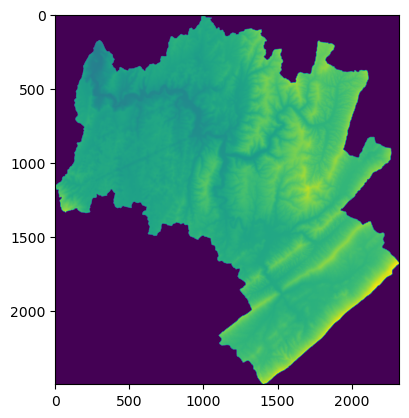

<Axes: >

In [5]:
riop.show(img_elev)

In [6]:
imgsrc_elev = rio.open(datadir+'HUC-0505000307-elev_cm.tif')
imgsrc_hyd = rio.open(datadir+'HUC-0505000307-hydrodem.tif')
imgsrc_sinks_hyd = rio.open(datadir+'HUC-0505000307-MonroeCo_Burned_3m_DEM_10kstreams.tif')
imgsrc_sinks = rio.open(datadir+'HUC-0505000307-MonroeCo_3m_DEM.tif')


In [7]:
sinks = clip_shp_to_geometry(clipname='HUC-0505000307-sinks-', 
                             shpdir=os.path.join(basedir, 'MonroeCtyWV','Lidar_derivedcl','MonroeCo_WV_sinkholes_shapefiles'),
                             shpfile='SinkholePolys.shp',
                             geom_df=second_creek,
                             outcrs=imgsrc_elev.crs
                             )

In [56]:
imgsrc_3dep1m = rio.open(basedir + '/MonroeCtyWV/3DEP-1m/USGS_one_meter_x54y417_WV_FEMA_R3_East_2016.tif')

sinks1m = clip_shp_to_geometry(clipname='HUC-0505000307-1m-sinks-', 
                             shpdir=os.path.join(basedir, 'MonroeCtyWV','Lidar_derivedcl','MonroeCo_WV_sinkholes_shapefiles'),
                             shpfile='SinkholePolys.shp',
                             geom_df=second_creek,
                             outcrs=imgsrc_3dep1m.crs
                             )
huc_sinks_1m = gpd.read_file(datadir+'HUC-0505000307-1m-sinks-SinkholePolys.shp')
huc_sinks_1m['ID'] = huc_sinks_1m.index.values
sinks_list_1m = huc_sinks_1m[['geometry','ID']].values.tolist()


# Rasterize for 1m section of Monroe Cty DEM
out_shape = imgsrc_3dep1m.shape
out_trans = imgsrc_3dep1m.transform
sinks_array_1m = rasterio.features.rasterize(sinks_list_1m,
                fill=-9999, out_shape= out_shape,
                transform = out_trans)

In [58]:
profile


{'driver': 'GTiff', 'dtype': 'int32', 'nodata': -3.4028234663852886e+38, 'width': 10012, 'height': 10012, 'count': 1, 'crs': CRS.from_epsg(26917), 'transform': Affine(1.0, 0.0, 539994.0,
       0.0, -1.0, 4170006.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [59]:
profile = imgsrc_3dep1m.profile
profile['nodata']=-9999
profile['dtype'] = 'int32'
with rasterio.open(datadir+'HUC-0505000307-sinks-1m-SinkholePolys.tif', 'w', **profile) as dest:
    dest.write(sinks_array_1m.astype(rasterio.int32), 1)

In [8]:
# Rasterize for NHD 1/3 arcsec dems
huc_sinks = gpd.read_file(datadir+'HUC-0505000307-sinks-SinkholePolys.shp')
huc_sinks['ID'] = huc_sinks.index.values
sinks_list = huc_sinks[['geometry','ID']].values.tolist()
out_shape = imgsrc_elev.shape
out_trans = imgsrc_elev.transform
sinks_array = rasterio.features.rasterize(sinks_list,
                fill=0, out_shape= out_shape,
                transform = out_trans)
profile = imgsrc_elev.profile
with rasterio.open(datadir+'HUC-0505000307-sinks-SinkholePolys.tif', 'w', **profile) as dest:
    dest.write(sinks_array.astype(rasterio.int32), 1)


In [9]:
sinks3m = clip_shp_to_geometry(clipname='HUC-0505000307-3m-sinks-', 
                             shpdir=os.path.join(basedir, 'MonroeCtyWV','Lidar_derivedcl','MonroeCo_WV_sinkholes_shapefiles'),
                             shpfile='SinkholePolys.shp',
                             geom_df=second_creek,
                             outcrs=imgsrc_sinks_hyd.crs
                             )
huc_sinks_3m = gpd.read_file(datadir+'HUC-0505000307-3m-sinks-SinkholePolys.shp')
huc_sinks_3m['ID'] = huc_sinks_3m.index.values
sinks_list_3m = huc_sinks_3m[['geometry','ID']].values.tolist()


# Rasterize for 3m Monroe Cty DEM
out_shape = imgsrc_sinks_hyd.shape
out_trans = imgsrc_sinks_hyd.transform
sinks_array_3m = rasterio.features.rasterize(sinks_list_3m,
                fill=-9999, out_shape= out_shape,
                transform = out_trans)
#sinks_array_3m.max()


In [10]:
profile = imgsrc_sinks_hyd.profile
profile['dtype'] = 'int32'
with rasterio.open(datadir+'HUC-0505000307-sinks-3m-SinkholePolys.tif', 'w', **profile) as dest:
    dest.write(sinks_array_3m.astype(rasterio.int32), 1)

In [11]:
sinksfile = os.path.join(datadir,'HUC-0505000307-sinks-SinkholePolys.tif')
wat_hyd = calc_karst_fraction(datadir=datadir,
                          demfile='HUC-0505000307-hydrodem.tif',
                          sinksfile=sinksfile,
                          mean_filter=False,
                          fill_pits=False)


./whitebox_tools --run="D8Pointer" --dem='/home/mcoving/github/sinkhole_analysis/HUC-0505000307-hydrodem.tif' --output='/home/mcoving/github/sinkhole_analysis/HUC-0505000307-hydrodem-d8.tif' -v --compress_rasters=False

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%

In [12]:
wat_elev = calc_karst_fraction(datadir=datadir,
                          demfile='HUC-0505000307-elev_cm.tif',
                          sinksfile=sinksfile,
                          mean_filter=False)


./whitebox_tools --run="FillSingleCellPits" --dem='/home/mcoving/github/sinkhole_analysis/HUC-0505000307-elev_cm.tif' --output='/home/mcoving/github/sinkhole_analysis/HUC-0505000307-elev_cm-pitfill.tif' -v --compress_rasters=False

*********************************
* Welcome to FillSingleCellPits *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progre

In [54]:
wat_elev_smoothed = calc_karst_fraction(datadir=datadir,
                          demfile='HUC-0505000307-elev_cm-smoothed.tif',
                          sinksfile=sinksfile,
                          mean_filter=False)#already smoothed

./whitebox_tools --run="FillSingleCellPits" --dem='/home/mcoving/github/sinkhole_analysis/HUC-0505000307-elev_cm-smoothed.tif' --output='/home/mcoving/github/sinkhole_analysis/HUC-0505000307-elev_cm-smoothed-pitfill.tif' -v --compress_rasters=False

*********************************
* Welcome to FillSingleCellPits *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Pr

<AxesSubplot: >

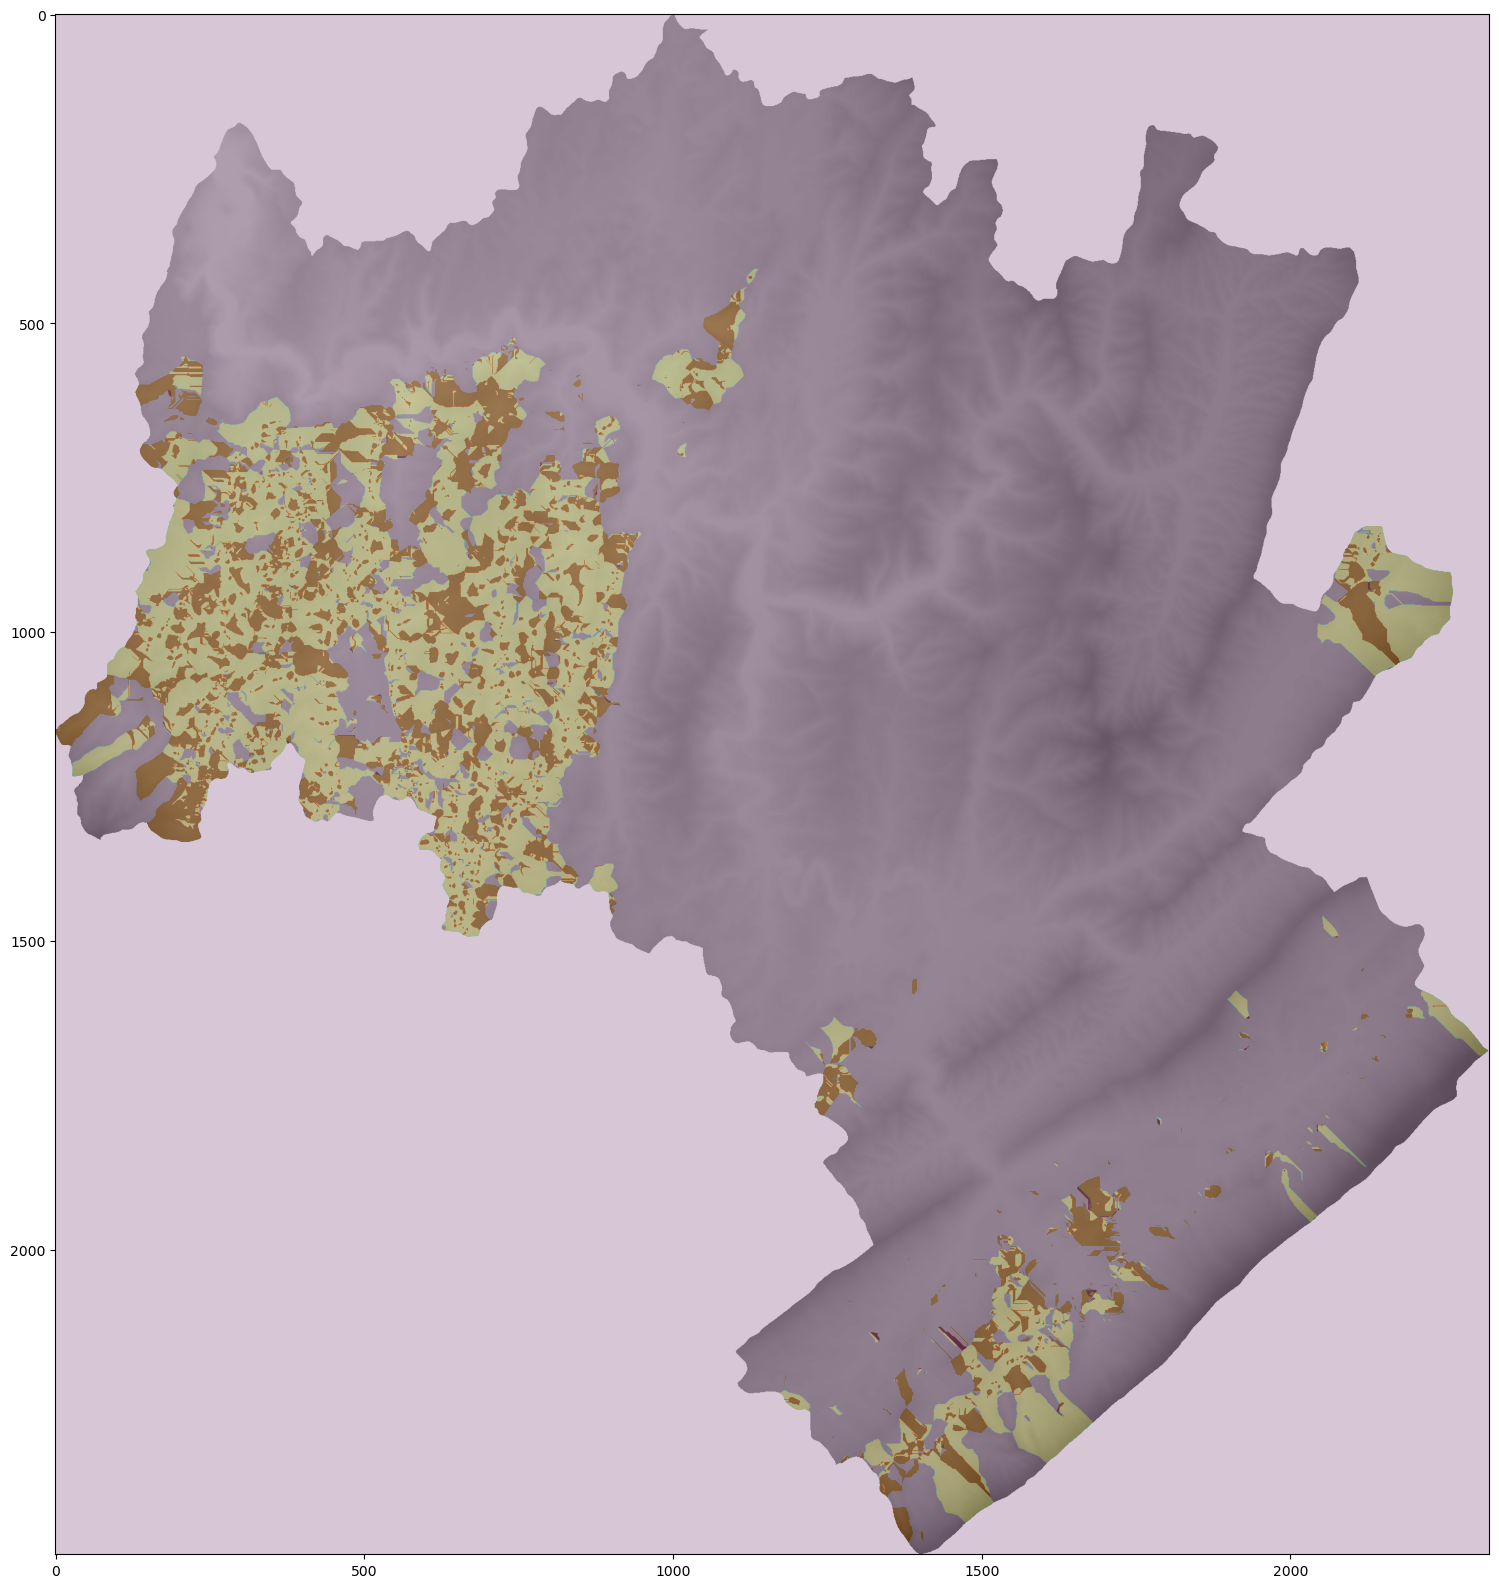

In [49]:
fig, ax = subplots(figsize=(20,20))
riop.show(img_elev, ax=ax, cmap='Greys')
riop.show(wat_elev, ax=ax, alpha=0.3)
riop.show(wat_hyd, ax=ax, alpha=0.3, cmap='Reds')

<AxesSubplot: >

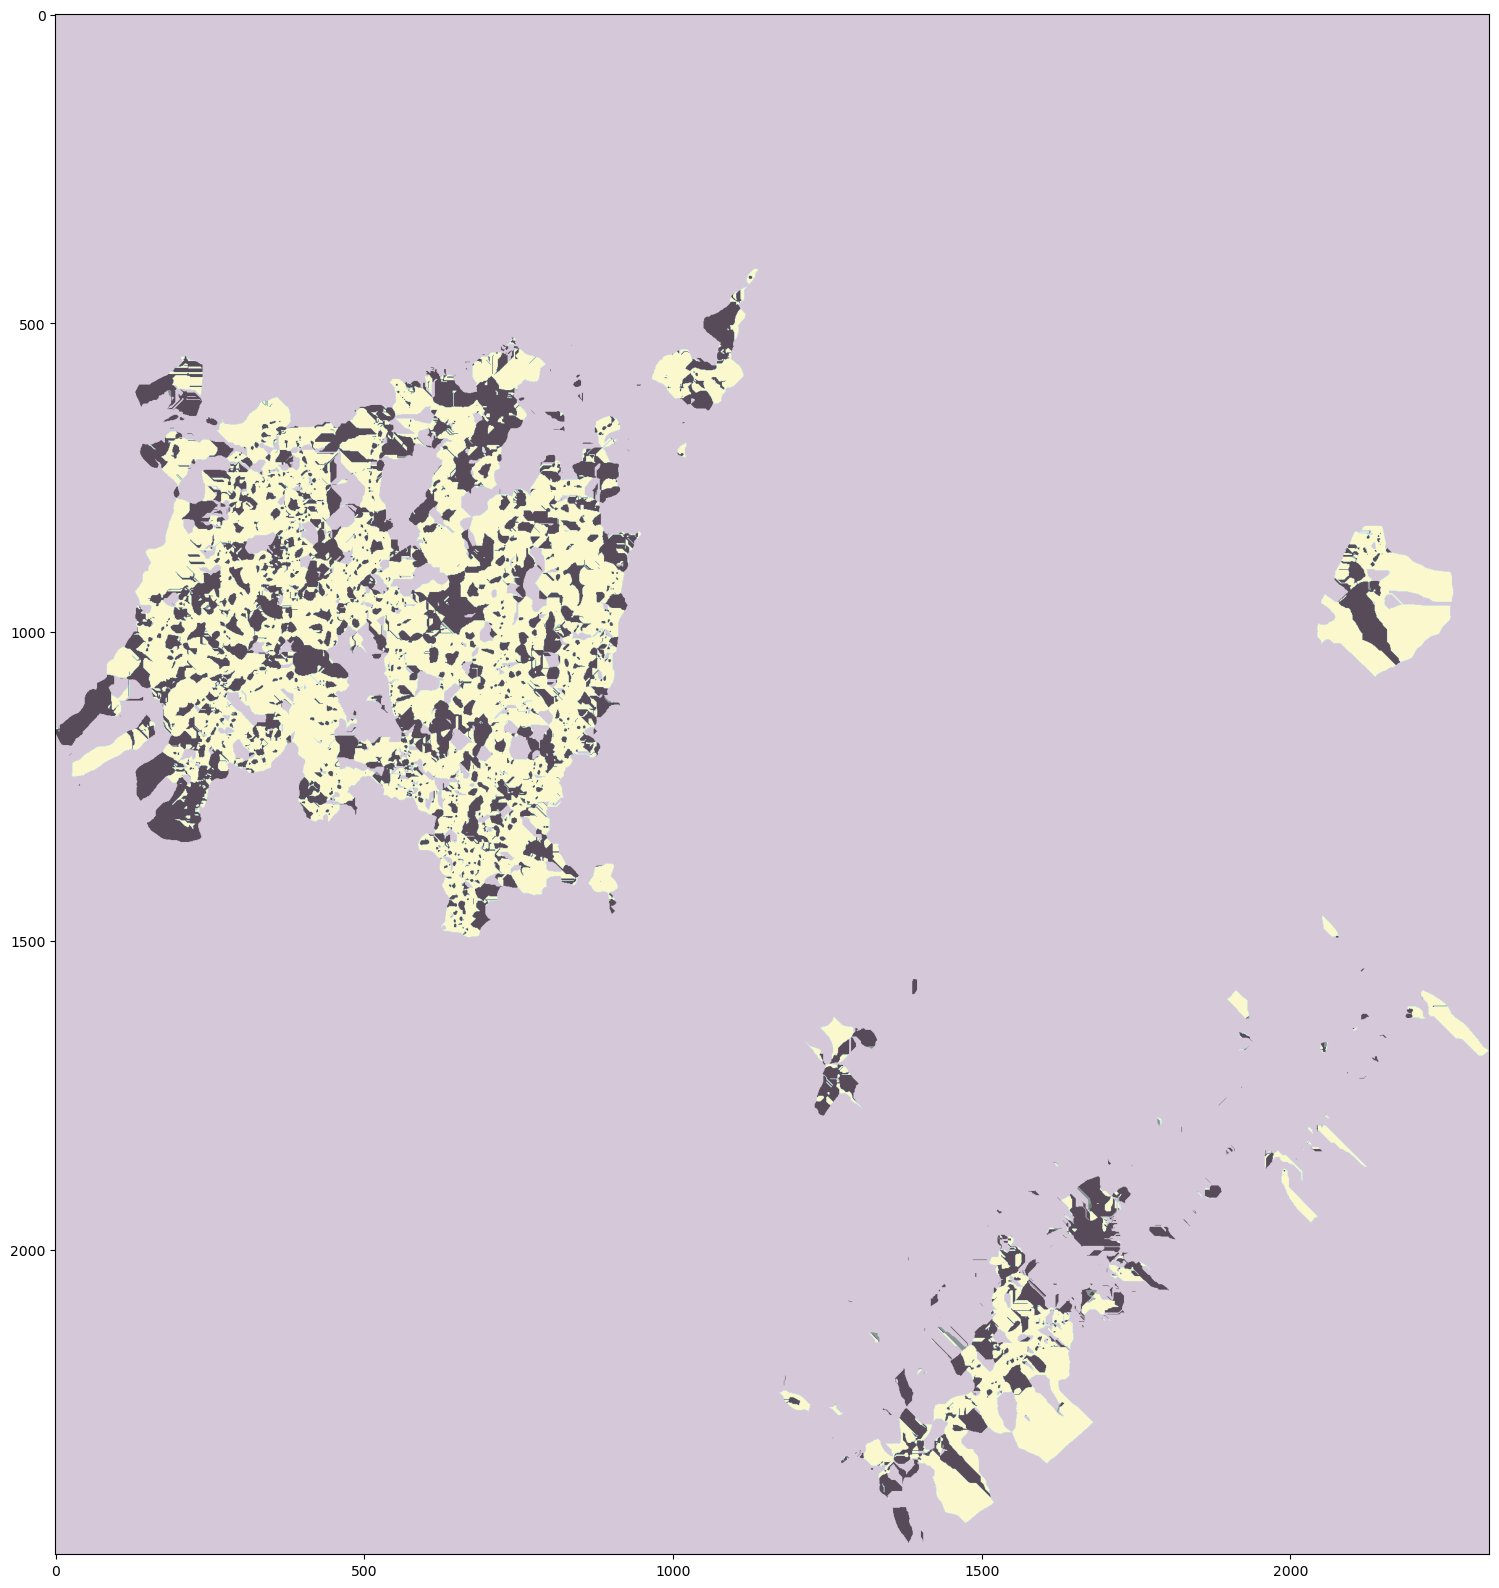

In [51]:
NHD_union = logical_and(wat_hyd > 0, wat_elev >0)
fig, ax = subplots(figsize=(20,20))
riop.show(NHD_union, ax=ax, cmap='Greys')
NHD_elev_only = logical_and(wat_hyd ==-32768, wat_elev >0)
riop.show(NHD_elev_only, ax=ax, alpha=0.3)
NHD_hyd_only = logical_and(wat_elev ==-32768, wat_hyd >-1)
riop.show(NHD_hyd_only, ax=ax, alpha=0.3, cmap='Greens')

Notes on analysis. From QGIS. Looked at diff between hydro dem and raw dem from NHD. Hydro dem has many sinks filled, which are often bigger than the single sinks from the dataset. This causes problems for flow routing using the NHD hydro dem for our purposes. This is probably why such small areas (often just around the sinks) are included when calculating catchments for sinks. Monroe Cty burned DEM also seems to miss some large catchment areas that should be counted. Not sure exactly why. So far, best results might be from Monroe Cty 3m dem. NHD dem smoothed on 5x5 grid seems to also do fairly well, maybe better than Monroe Cty 3m. Note that NHDPlus dems are 1/3 arcsec (10 m). Initial pass with 1m 3dep dem doesn't seem to to better (maybe not as well).

In [53]:
profile = imgsrc_elev.profile
with rasterio.open(datadir+'NHD-Elev-Only.tif', 'w', **profile) as dest:
    dest.write(NHD_elev_only[0].astype(rasterio.int32), 1)


In [15]:
sinksfile = os.path.join(datadir,'HUC-0505000307-sinks-3m-SinkholePolys.tif')
wat_sinks_hyd = calc_karst_fraction(datadir=datadir,
                          demfile='HUC-0505000307-MonroeCo_Burned_3m_DEM_10kstreams.tif',
                          sinksfile=sinksfile,
                          mean_filter=False,
                          fill_pits=False)

./whitebox_tools --run="D8Pointer" --dem='/home/mcoving/github/sinkhole_analysis/HUC-0505000307-MonroeCo_Burned_3m_DEM_10kstreams.tif' --output='/home/mcoving/github/sinkhole_analysis/HUC-0505000307-MonroeCo_Burned_3m_DEM_10kstreams-d8.tif' -v --compress_rasters=False

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progr

In [16]:
sinksfile = os.path.join(datadir,'HUC-0505000307-sinks-3m-SinkholePolys.tif')
wat_sinks = calc_karst_fraction(datadir=datadir,
                          demfile='HUC-0505000307-MonroeCo_3m_DEM.tif',
                          sinksfile=sinksfile,
                          mean_filter=True,
                          fill_pits=True)

./whitebox_tools --run="MeanFilter" --input='/home/mcoving/github/sinkhole_analysis/HUC-0505000307-MonroeCo_3m_DEM.tif' --output='/home/mcoving/github/sinkhole_analysis/HUC-0505000307-MonroeCo_3m_DEM-smoothed.tif' --filterx=5 --filtery=5 -v --compress_rasters=False

****************************
* Welcome to MeanFilter    *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Creating integral images: 0%
Creating integral images: 1%
Creating integral images: 2%
Creating integral images: 3%
Creating integral images: 4%
Creating integral images: 5%
Creating integral images: 6%
Creating integral images: 7%
Creating integral images: 8%
Creating integral images: 9%
Creating integral images: 10%
Creating integral images: 11%
Creating integral images: 12%
Creating integral images: 13%
Creating integral images: 14%
Creating integral images: 15%
Creating integral images: 16%
Creating integral images: 17%
Creating integral images: 18%
Creating int

In [17]:
wat_sinks.max()

-32768

array([[[-32768, -32768, -32768, ..., -32768, -32768, -32768],
        [-32768, -32768, -32768, ..., -32768, -32768, -32768],
        [-32768, -32768, -32768, ..., -32768, -32768, -32768],
        ...,
        [-32768, -32768, -32768, ..., -32768, -32768, -32768],
        [-32768, -32768, -32768, ..., -32768, -32768, -32768],
        [-32768, -32768, -32768, ..., -32768, -32768, -32768]]],
      dtype=int32)

In [60]:
sinksfile = os.path.join(datadir,'HUC-0505000307-sinks-1m-SinkholePolys.tif')
wat_sinks = calc_karst_fraction(datadir='/home/mcoving/Dropbox/sync/projects/Dolines/MonroeCtyWV/3DEP-1m'
                                ,
                          demfile='USGS_one_meter_x54y417_WV_FEMA_R3_East_2016.tif',
                          sinksfile=sinksfile,
                          mean_filter=True,
                          fill_pits=True)

./whitebox_tools --run="MeanFilter" --input='/home/mcoving/Dropbox/sync/projects/Dolines/MonroeCtyWV/3DEP-1m/USGS_one_meter_x54y417_WV_FEMA_R3_East_2016.tif' --output='/home/mcoving/Dropbox/sync/projects/Dolines/MonroeCtyWV/3DEP-1m/USGS_one_meter_x54y417_WV_FEMA_R3_East_2016-smoothed.tif' --filterx=5 --filtery=5 -v --compress_rasters=False

****************************
* Welcome to MeanFilter    *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Creating integral images: 0%
Creating integral images: 1%
Creating integral images: 2%
Creating integral images: 3%
Creating integral images: 4%
Creating integral images: 5%
Creating integral images: 6%
Creating integral images: 7%
Creating integral images: 8%
Creating integral images: 9%
Creating integral images: 10%
Creating integral images: 11%
Creating integral images: 12%
Creating integral images: 13%
Creating integral images: 14%
Creating integral images: 15%
Creating integral images: 

In [1]:
from karstification import calc_karstification_for_HU10

In [2]:
wat = calc_karstification_for_HU10('0505000307')

./whitebox_tools --run="FillSingleCellPits" --dem='./HUC-0505000307-elev_cm.tif' --output='./HUC-0505000307-elev_cm-pitfill.tif' -v --compress_rasters=False

*********************************
* Welcome to FillSingleCellPits *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
thread 'main' panicked at 'No such file or directory (os error 2)', whitebox-tools-app/src/main.rs:72:21
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace
./whitebox_tools --run="D8Pointer" --dem='./HUC-0505000307-elev_cm-pitfill.tif' --output='./HUC-0505000307-elev_cm-d8.tif' -v --compress_rasters=False

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
thread 'main' panicked at 'No such file or directory (os error 2)', whitebox-tools-app/src/main.rs:72:21
note: run with `RUST_BACKTRACE=1` environment variable to display a bac

AttributeError: 'NoneType' object has no attribute '__annotations__'